#About the Data

* The data was taken from https://www.finra.org/rules-guidance/key-topics 

* The Data consist of three columns: Rule, Text and Topic.
  - Rule: FINRA Rule number. 
  - Text: List of rules.
  - Topic: Category to which the rule belongs.

* Each rule under the Key Topics:<br>

  1. Anti-Money Laundering
  2. Broker-Dealer Recruitment Disclosures: Complying with FINRA Rule 2273
  3. Business Continuity Planning
  4. Subordination Agreements 

are taken as a text.

* Each new line of the Rule Book was converted into text.
* Blank text is not considered.
* Prefixes in the beginning of the rules are retained.
* The word ‘and’ to indicate the last rule is removed.
* No summarization was done.


# Text Preprocessing

* Sentences containing more than 30 words are considered.
* Duplicate ‘Text’ are removed.


#Fine Tuning DistilBERT model for text classification

* The model was trained on 15 epochs and the learning rate was set at 2e-5 and batch size 6

* Total time taken to create the dataframe with top 3 rank of predictions in the test data is :  0:00:35 (h:mm:ss)

* Data Split:<br>
      -Training data: 18 (60 percent)
      -Validation data: 6 (20 percent)
      -Test Data : 6 (20 percent)

* Macro-averaged f1-score<br>
      -Training data: 1.00  
      -Validation data: 0.70 
      -Test data: 0.53  



##Memory Allocated

In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

13G


##Google Drive access

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Path

In [ ]:
# write the appropriate paths to retrieve the data and store results 
saved_path = '/content/drive/MyDrive/Full_Code/FINRA/Strategy1/DistilBERT/Epochs_15/'
used_test_data_path = saved_path  + "Test_data_DistilBERT.csv"

## Set-up environment

Install the libraries folium version 0.2.1, HuggingFace Transformers and Datasets

In [ ]:
#Install the package folium version 0.2.1 and HuggingFace tranformer and datasets libraries  
!pip install -q folium==0.2.1 transformers datasets 

     |████████████████████████████████| 69 kB 4.2 MB/s 
     |████████████████████████████████| 4.2 MB 24.8 MB/s 
     |████████████████████████████████| 346 kB 45.2 MB/s 
     |████████████████████████████████| 596 kB 42.7 MB/s 
     |████████████████████████████████| 6.6 MB 44.9 MB/s 
     |████████████████████████████████| 86 kB 3.7 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |████████████████████████████████| 140 kB 47.2 MB/s 
     |████████████████████████████████| 212 kB 47.2 MB/s 
     |████████████████████████████████| 86 kB 5.0 MB/s 
     |████████████████████████████████| 127 kB 56.8 MB/s 
     |████████████████████████████████| 271 kB 45.8 MB/s 
     |████████████████████████████████| 144 kB 57.4 MB/s 
     |████████████████████████████████| 94 kB 1.3 MB/s 


In [ ]:
#Check if GPU is available
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device, "is available")

cpu is available


## Loading the Dataset

In [ ]:
#Load the data
import pandas as pd
test_data_df = pd.read_csv(used_test_data_path)
test_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  6 non-null      object
 1   label     6 non-null      object
dtypes: object(2)
memory usage: 224.0+ bytes


Example

In [ ]:
test_data_df.loc[0,'sentence']

'(c) Provide for annual (on a calendar-year basis) independent testing for compliance to be conducted by member personnel or by a qualified outside party, unless the member does not execute transactions for customers or otherwise hold customer accounts or act as an introducing broker with respect to customer accounts (e.g., engages solely in proprietary trading or conducts business only with other broker-dealers), in which case such "independent testing" is required every two years (on a calendar-year basis).'

In [ ]:
test_data_df.loc[0,'label']

'Anti-Money Laundering'

In [ ]:
#Import the librarires required for the function get_top3_rank
import torch
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import logging
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW 
from transformers import pipeline
import numpy as np
import time

In [ ]:
#Create a function for formatting elapsed times as hh:mm:ss
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def get_top3_rank(df,column_name):
  """
  df: the input dataframe containg text
  column_name : the text column containg the input text
  the function get_top3_rank outputs rank_df the dataframe that contains the top 3 ranks
  """
  ############################################################################################################
  #Function to create DistilBERT pipeline
  ############################################################################################################
  def get_rank_dataframe(df,column_name):
    """
    df: the input dataframe containg text
    column_name : the text column containg the input text
    the function get_rank_dataframe returns the dataframe with top3 ranks
    """
    ############################################################################################################
    #Check if GPU is Available or not
    ############################################################################################################
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    ############################################################################################################
    #Write the appropriate paths to retrieve the data 
    ############################################################################################################
    user_path = '/content/drive/MyDrive/Full_Code/FINRA/Strategy1/DistilBERT/Epochs_15/'
    best_model_path = user_path + "best_model/best_model.pt"
    label2id_df_path = user_path + "label2id_df.csv"
    ############################################################################################################
    #Create a label2id dictionary to map label and index
    ############################################################################################################
    labels2id_df = pd.read_csv(label2id_df_path)
    labels = labels2id_df.columns.to_list()
    ids = [int(i) for i in labels2id_df.loc[0,:]]
    id2label = {A: B for A, B in zip(ids, labels)} 
    label2id = {A: B for A, B in zip(labels,ids)} 
    labels = list(labels)
    ############################################################################################################
    #Load the tokenizer
    ############################################################################################################
    tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased',num_labels=len(labels))
    logging.set_verbosity_error()
    ############################################################################################################
    #Load the best model
    ############################################################################################################
    model_best = AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)


    model_best.to(device)
    ############################################################################################################
    #SET THE PARAMETERS
    fixed_learning_rate = 2e-5
    fixed_batch_size = 6
    ############################################################################################################
    #LOAD THE OPTIMZER
    #Optimizer
    optimizer_best = AdamW(model_best.parameters(),lr = fixed_learning_rate)
    ############################################################################################################
    # The function load_chkp is created for loading model
    def load_ckp(checkpoint_fpath, model, optimizer):
      """
      checkpoint_path: path to save checkpoint
      model: model that we want to load checkpoint parameters into       
      optimizer: optimizer we defined in previous training
      """
      # load check point
      checkpoint = torch.load(checkpoint_fpath,map_location=torch.device('cpu'))
      # initialize state_dict from checkpoint to model
      model.load_state_dict(checkpoint['state_dict'])
      # initialize optimizer from checkpoint to optimizer
      optimizer.load_state_dict(checkpoint['optimizer'])
      # initialize valid_loss_min from checkpoint to valid_loss_min
      valid_loss_min = checkpoint['valid_loss_min']
      # return model, optimizer, epoch value, min validation loss 
      return model, optimizer, checkpoint['epoch'], valid_loss_min

    # load the saved checkpoint
    model_best, optimizer_best, end_epoch, valid_loss_min = load_ckp(best_model_path, model_best, optimizer_best)
    ############################################################################################################
    #Get inference from the DistilBERT pipline
    ############################################################################################################  
    #set the device_value
    if device == 'cuda:0':
        device_value = 0
    else:
        device_value =-1

     #Create the DistilBERT pipeline
    MAX_LENGTH = model_best.config.max_position_embeddings
  
    distilbert_nlp = pipeline(task="sentiment-analysis", return_all_scores = True, model=model_best, tokenizer=tokenizer,
                              device= device_value, max_length = MAX_LENGTH , truncation=True)
    ############################################################################################################
    #Return the result in a data frame
    ############################################################################################################
    labels_rank_list=[]
    labels_score_list=[]
    def get_rank(example,fix_rank = 3):
      result_value = distilbert_nlp(example)
      sorted_value = sorted(result_value[0], key=lambda k: k['score'],reverse = True)
      new_dictionary_label = {'predicted_label_' + str(i+1): sorted_value[i]['label'] for i in range(fix_rank)}
      new_dictionary_score = {'predicted_percentage_' + str(i+1): 100 * sorted_value[i]['score'] for i in range(fix_rank)}
      labels_rank_list.append(new_dictionary_label)
      labels_score_list.append(new_dictionary_score)
    df[column_name].map(lambda row : get_rank(row,fix_rank = 3))
    list2d_rank = {key: [i[key] for i in labels_rank_list] for key in labels_rank_list[0]}
    list2d_score = {key: [i[key] for i in labels_score_list] for key in labels_score_list[0]}
    predicted_dataframe = pd.concat([df,pd.DataFrame(list2d_rank),pd.DataFrame(list2d_score)], axis=1)
    predicted_dataframe.rename(columns = {'label':'true_label'}, inplace = True)
    return predicted_dataframe
  start_t0 = time.time()
  rank_df = get_rank_dataframe(df,column_name)
  print("\nTotal time taken to create the dataframe: {:} (h:mm:ss)".format(format_time(time.time() - start_t0)))
  return rank_df

In [ ]:
#Call the function get_top3_rank using the input test_data_df and 'sentence' column in test_data_df to return the dataframe with top 3 rank
top3_df = get_top3_rank(test_data_df,'sentence')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]


Total time taken to create the dataframe: 0:00:35 (h:mm:ss)


In [ ]:
#Display the first five entries in the data frame top3_df
top3_df.head()

,sentence,true_label,predicted_label_1,predicted_label_2,predicted_label_3,predicted_percentage_1,predicted_percentage_2,predicted_percentage_3
0,(c) Provide for annual (on a calendar-year bas...,Anti-Money Laundering,Subordination Agreements,Business Continuity Planning,Broker-Dealer Recruitment Disclosures: Complyi...,39.421436,26.178211,22.457600
1,"(A) If the contact is in writing, the written ...",Broker-Dealer Recruitment Disclosures: Complyi...,Broker-Dealer Recruitment Disclosures: Complyi...,Business Continuity Planning,Subordination Agreements,37.828669,25.611061,20.940493
2,(a) Each member must create and maintain a wri...,Business Continuity Planning,Business Continuity Planning,Subordination Agreements,Broker-Dealer Recruitment Disclosures: Complyi...,35.943982,32.355145,19.879815
3,(c)(1) No equity capital of a member may be wi...,Subordination Agreements,Subordination Agreements,Business Continuity Planning,Broker-Dealer Recruitment Disclosures: Complyi...,68.188435,14.434132,9.826805
4,"(f)(1) Each member shall report to FINRA, via ...",Business Continuity Planning,Broker-Dealer Recruitment Disclosures: Complyi...,Business Continuity Planning,Subordination Agreements,33.589447,32.308015,21.907769


Let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [ ]:
label2id_df_path = '/content/drive/MyDrive/Full_Code/FINRA/Strategy1/DistilBERT/Epochs_15/label2id_df.csv'
labels2id_df = pd.read_csv(label2id_df_path)
labels2id_df

,Anti-Money Laundering,Broker-Dealer Recruitment Disclosures: Complying with FINRA Rule 2273,Business Continuity Planning,Subordination Agreements
0,0,1,2,3


In [ ]:
labels = labels2id_df.columns.to_list()
ids = [int(i) for i in labels2id_df.loc[0,:]]
id2label = {A: B for A, B in zip(ids, labels)} 
label2id = {A: B for A, B in zip(labels,ids)} 
labels = list(labels)

The dataset consists of 4 labels.

The confusion matrix is : 



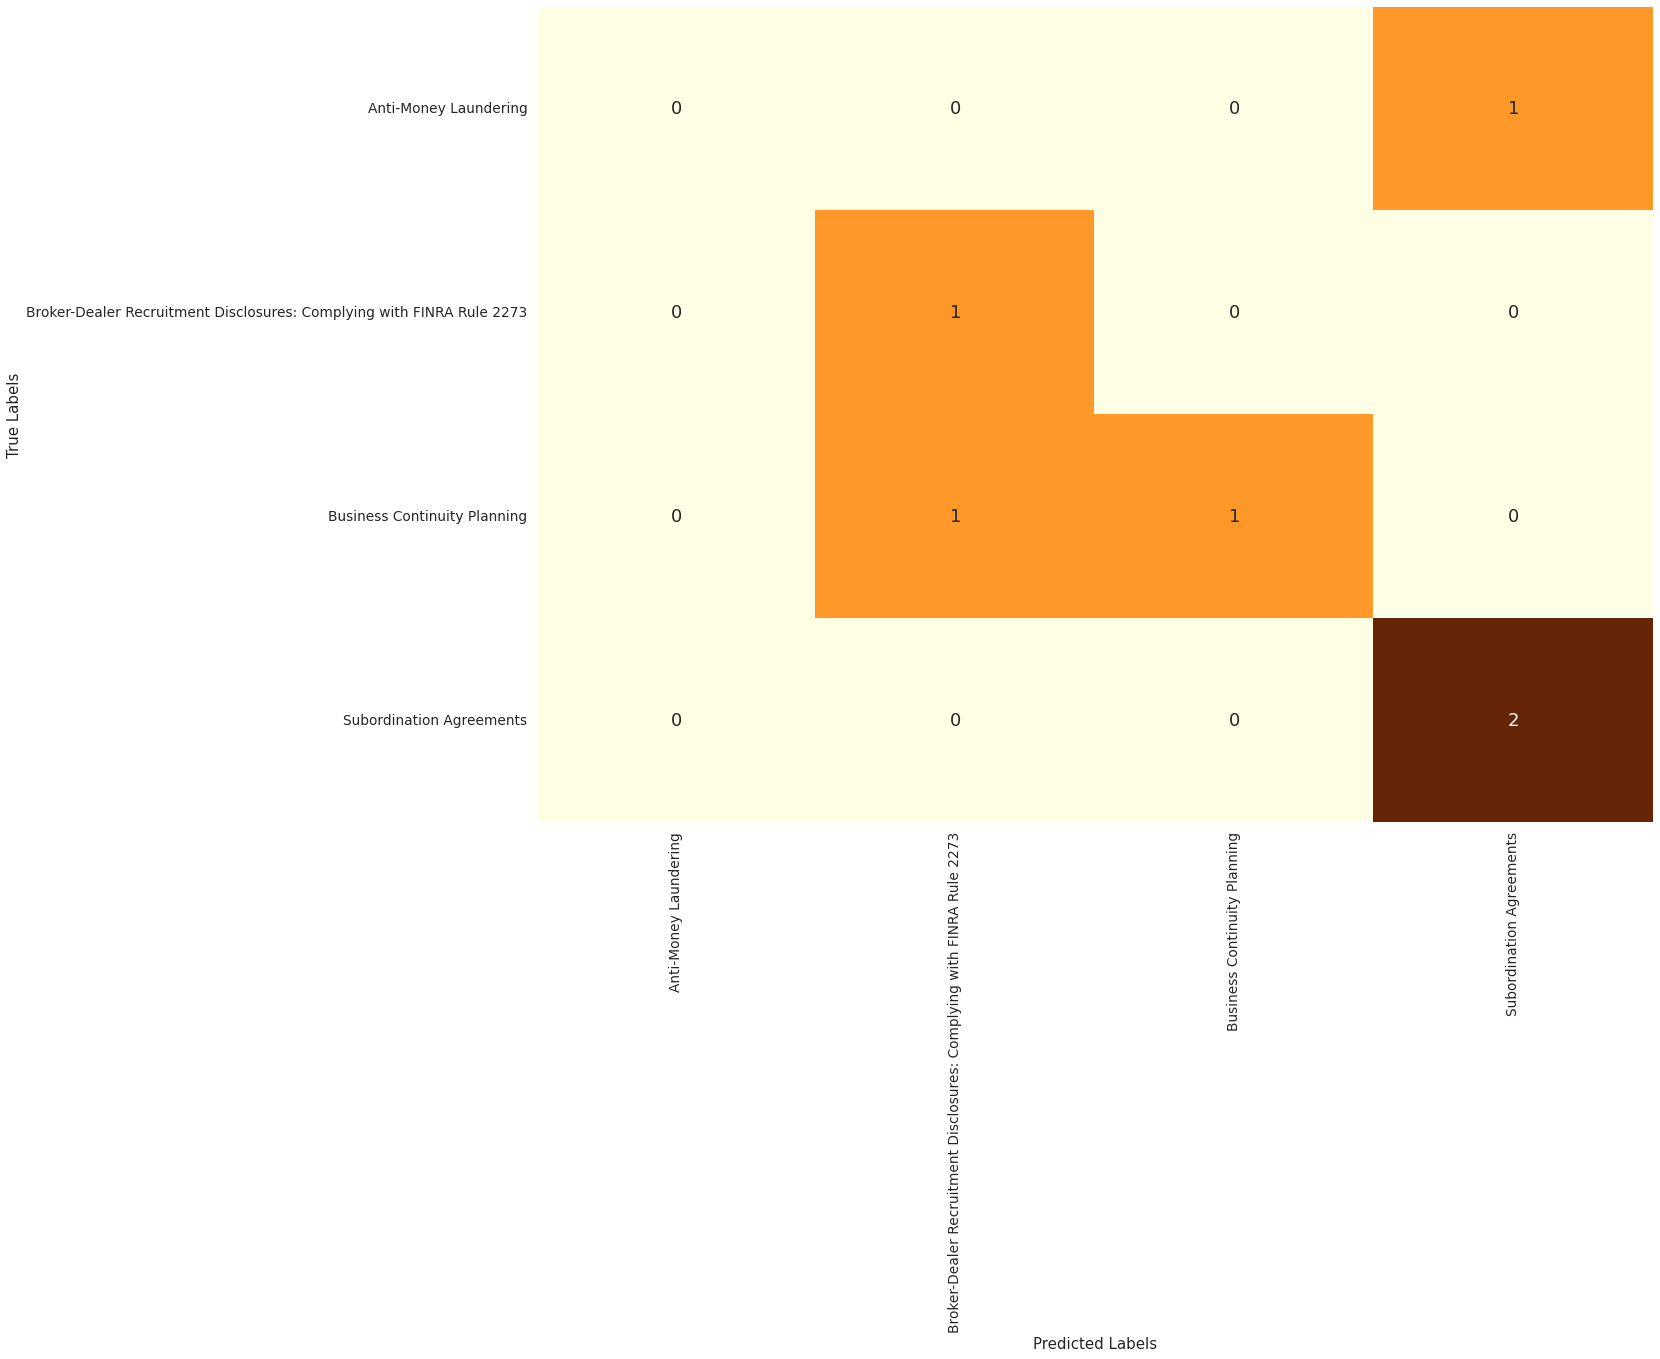

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
True_labels = top3_df["true_label"].to_list() 
Predicted_labels = top3_df["predicted_label_1"].to_list() 
cm = confusion_matrix(True_labels, Predicted_labels)
#plot the confusion matrix
print("The confusion matrix is : \n")
plt.figure(figsize=(20,15))
sns.set(font_scale=1.25)
ax =sns.heatmap(cm, annot=True, fmt='d',cbar=False,xticklabels=labels, yticklabels=labels,cmap="YlOrBr",annot_kws={"size": 18})
ax.set(xlabel='Predicted Labels', ylabel='True Labels')
plt.show()

In [ ]:
#Display Classification Report
from sklearn.metrics import classification_report
print(classification_report(True_labels, Predicted_labels,zero_division=0))

                                                                       precision    recall  f1-score   support

                                                Anti-Money Laundering       0.00      0.00      0.00         1
Broker-Dealer Recruitment Disclosures: Complying with FINRA Rule 2273       0.50      1.00      0.67         1
                                         Business Continuity Planning       1.00      0.50      0.67         2
                                             Subordination Agreements       0.67      1.00      0.80         2

                                                             accuracy                           0.67         6
                                                            macro avg       0.54      0.62      0.53         6
                                                         weighted avg       0.64      0.67      0.60         6



In [ ]:
# Calculate the First Prediction Percentages
top3_df["First_Prediction_Percentage"] = (top3_df["true_label"]  == top3_df['predicted_label_1']) * 100
# Calculate the First and Second Prediction Percentages
top3_df["First_and_Second_Prediction_Percentage"] = ((top3_df["true_label"]  == top3_df['predicted_label_1']) |((top3_df["true_label"]  == top3_df['predicted_label_2']))) * 100

In [ ]:
# Calculate the accuracy of First and Second Predictions
accuracy_df = top3_df.loc[:,['true_label',"First_Prediction_Percentage", "First_and_Second_Prediction_Percentage"]].groupby('true_label').mean() 
accuracy_df 

,First_Prediction_Percentage,First_and_Second_Prediction_Percentage
true_label,,
Anti-Money Laundering,0.0,0.0
Broker-Dealer Recruitment Disclosures: Complying with FINRA Rule 2273,100.0,100.0
Business Continuity Planning,50.0,100.0
Subordination Agreements,100.0,100.0
